In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=f510fc95af6efad0b09c267092aeb120d12a2a330859596c40a65f8c7af54f2c
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from imutils import paths
import imutils
import random as rd
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import img_to_array
from keras.losses import MAE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [11]:
datadir='/kaggle/input'

files = sorted(list(paths.list_images(datadir)))

rd.shuffle(files)

images = []
labels = []
dims = (96, 96, 3)

for filename in files:
    img = cv.imread(filename)
    img = cv.resize(img, (96, 96))
    img = img_to_array(img)
    images.append(img)
    
    lbl = filename.split(os.path.sep)[-2].split("_")
    labels.append(lbl)
    
images = np.array(images, dtype="float") / 255
labels = np.array(labels)

In [12]:
images.shape

(16170, 96, 96, 3)

In [13]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

print("class labels:")
print(mlb.classes_)

print("example binarized label:")
print(labels[0])

class labels:
['black' 'blue' 'brown' 'dress' 'green' 'hoodie' 'pants' 'pink' 'red'
 'shirt' 'shoes' 'shorts' 'silver' 'skirt' 'suit' 'white' 'yellow']
example binarized label:
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]


In [14]:
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.3, random_state=42)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(11319, 96, 96, 3) (4851, 96, 96, 3) (11319, 17) (4851, 17)


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, 3),  # Menggunakan filter pooling yang lebih besar
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(17, activation='sigmoid')
])

model.compile(loss=MAE, optimizer= Adam(learning_rate=1e-3, decay=0.00005),
              metrics=["accuracy"])

In [16]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only = True, monitor = 'val_loss', verbose = 1)

In [17]:
to_json = model.to_json()

with open('model.json', 'w') as f:
    f.write(to_json)

In [18]:
history = model.fit(trainX, trainY,
                    batch_size=64,
                    validation_data = (testX, testY), 
                    epochs = 100, verbose = 1, 
                    callbacks = [checkpoint])

Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.4064
Epoch 1: val_loss improved from inf to 0.13095, saving model to best_model.h5
177/177 [==============================] - 403s 2s/step - loss: 0.1602 - accuracy: 0.4064 - val_loss: 0.1309 - val_accuracy: 0.0328
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.5039
Epoch 2: val_loss improved from 0.13095 to 0.10709, saving model to best_model.h5
177/177 [==============================] - 398s 2s/step - loss: 0.0468 - accuracy: 0.5039 - val_loss: 0.1071 - val_accuracy: 0.1513
Epoch 3/100
177/177 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.5091
Epoch 3: val_loss improved from 0.10709 to 0.05830, saving model to best_model.h5
177/177 [==============================] - 397s 2s/step - loss: 0.0337 - accuracy: 0.5091 - val_loss: 0.0583 - val_accuracy: 0.3249
Epoch 4/100
177/177 [==============================] - ETA: 0s - loss: 

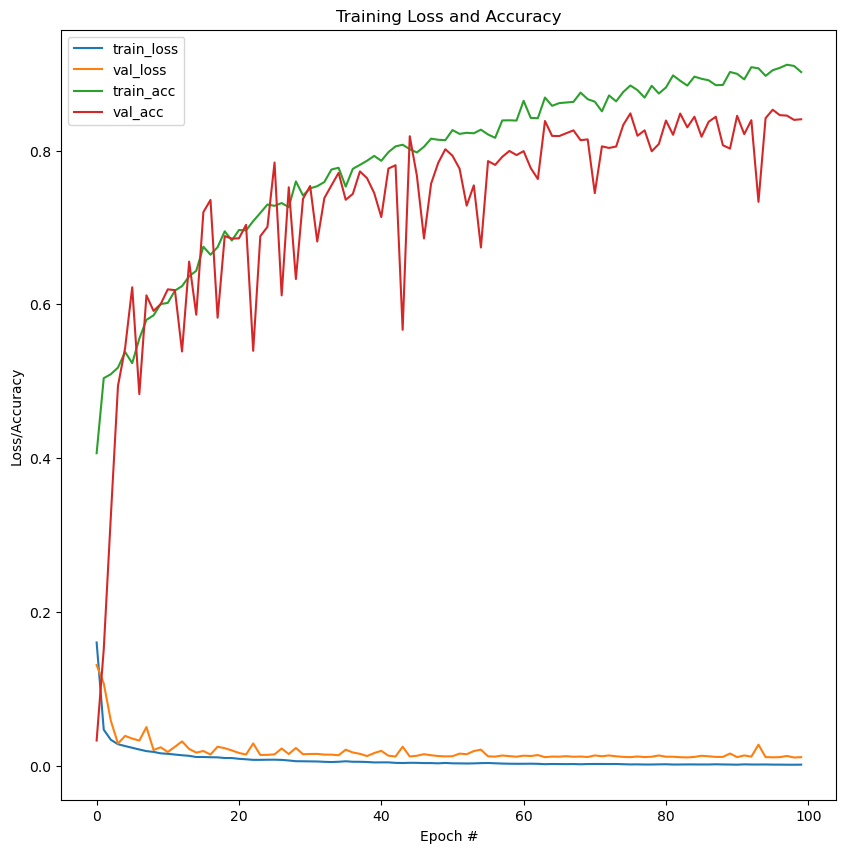

In [22]:
plt.figure(figsize=(10,10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [32]:
def predict (path: str):
    img = cv.imread(path)
    img = cv.resize(img, (96, 96))
    img = img.astype("float") / 255
    img = img_to_array(img)
    img = np.expand_dims(img / 255, axis=0)
    pred = model.predict(img)
    return mlb.classes_[pred]

In [33]:
predict('/kaggle/input/apparel-dataset/black_dress/105.jpg')

1/1 [==============================] - 0s 37ms/step


IndexError: arrays used as indices must be of integer (or boolean) type